# Imports

In [1]:
import urllib
import os
import operator
import pathlib
import requests
from joblib import dump, load
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/X_train.csv
	../data/raw/shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

## Read labeled training and TEST data and subset predictors and response variable

In [ ]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [ ]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [ ]:
# summarize dataframe info
print('Y TRAIN DATA WITH ADDITIONAL LABELS\n')
y_train_labels.info()
print('\n\nX TRAIN DATA WITH ADDITIONAL LABELS\n')
X_train_labels.info()
print('\n\nX TRAIN PREDICTORS (WITH LABEL COLUMNS EXCLUDED)\n')
print(predictor_columns)
print('\n\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY\n')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\n\nX SCALER DATA INFO\n')
X_scaler.info()
print(
    '\n\nTHE X SCALER DATA CONTAINS MEANS AND STDS FOR THE FOLLOWING STANDARDIZED '\
    '(i.e. SCALED) PREDICTORS\n\n{}'.format(X_scaler['scaled-feature'].values)
)

In [ ]:
# create lists of predictors based on numeric type for easier treatment of specific types
predictors_binary = [
    'night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
    'college-near', 'highschool-near'
]
predictors_nonbinary = [col for col in X_train.columns if col not in predictors_binary]
predictors_discrete = [
    'streetlights-night',
    'median-age',
]
predictors_continuous = [col for col in predictors_nonbinary if col not in predictors_discrete]

print(
    'Binary predictors in the X training data are:\n\n{}\n\n\n'\
    'Non-binary predictors are:\n\n{}\n\n\n'\
    'Of the non-binary, the following are discrete:\n\n{}\n\n\n'\
    'And these remaining are continuous:\n\n{}\n'.format(
        predictors_binary,
        predictors_nonbinary,
        predictors_discrete,
        predictors_continuous
    )
)

## Inspect multi-collinearity of predictors

In [ ]:
def sort_pairwise_correlation(X_train):
    """
    Calculates a correlation matrix of all input predictors and observations,
    via the X_train dataframe, then returns a sorted dataframe of all
    pairwise correlation values (duplicates and same-value pairings removed).
    
    The returned sorted correlation summary dataframe is sorted in descending
    order, from highest to lowest correlation pairings.
    """
    # calculate correlation among all predictors
    correlation_matrix_df = X_train.corr()
    correlation_abs_matrix_df = X_train.corr().abs()

    # identify variables most heavily correlated in descending order
    # and remove pairwise groupings of the same predictors
    corr_unstack = correlation_abs_matrix_df.unstack()
    corr_sorted = corr_unstack.sort_values(ascending=False)
    corr_sorted = corr_sorted[corr_sorted < 1][::2]
    
    return corr_sorted


In [ ]:
#############################################
## Calculate and report on pairwise correlations
#############################################

# generate sorted correlation dataframe
corr_df = sort_pairwise_correlation(X_train)

# set corr threshold for reporting
corr_thresh = 0.50

print(
    '\nThe most strongly correlated predictors (corr > {0:.2f}) in our baseline model '\
    'predictor set and their corresponding correlation values are:\n\n{1}\n'.format(
        corr_thresh,
        corr_df[corr_df > corr_thresh],
    )
)

## Create value count summary tables by crime-type for later reference

In [ ]:
agg_dict = {'INCIDENT_NUMBER': 'count'}

crime_types_train = y_train_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_train['proportion'] = crime_types_train / crime_types_train.sum()

crime_types_test = y_test_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_test['proportion'] = crime_types_test / crime_types_test.sum()

# create dictionary of crime types for later use
class_dict = dict(
    zip(crime_types_test.reset_index()['crime-type'], crime_types_test.reset_index()['crime-type-cat'])
)

In [ ]:
class_dict

In [ ]:
print(
    'The number of observed crime type classes in both the training and test set are:\n\n'\
    'TRAINING\n{}\n\n\nTEST\n{}\n'.format(
        crime_types_train,
        crime_types_test
    )
)

# Intepretability

In [121]:
model2 = tf.keras.load('../models/basic-nn.h5')

AttributeError: module 'tensorflow.python.keras.api._v1.keras' has no attribute 'load'

In [91]:
predictor_ranges = {}
no_vals = 20
median = X_train_scaled.median().values.reshape(1, -1)
for i, label in enumerate(X_train_scaled.columns):
    low, hi = X_test_scaled[label].min(), X_test_scaled[label].max()
    arr = np.array([median[0] for _ in range(no_vals)])
    arr[:, i] = np.linspace(low, hi, no_vals)
    predictor_ranges[label] = arr

In [113]:
interesting_cols = ['streetlights-night', 'night', 'tempavg', 'precip', 'snowfall',
                    'college-near', 'highschool-near', 'poverty-rate',
                    'residential-median-value', 'residential-gini-coef',]

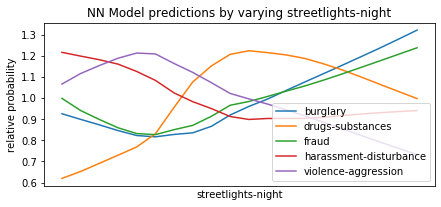

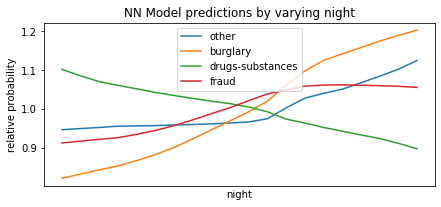

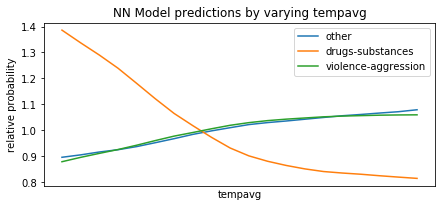

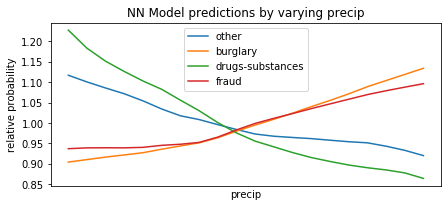

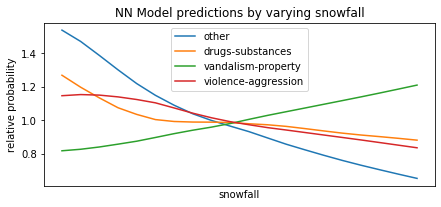

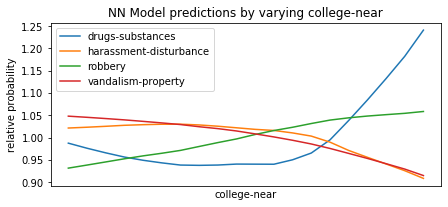

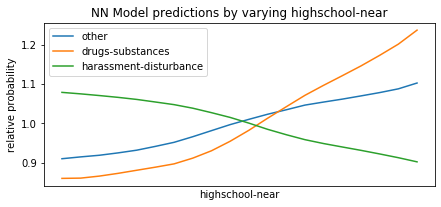

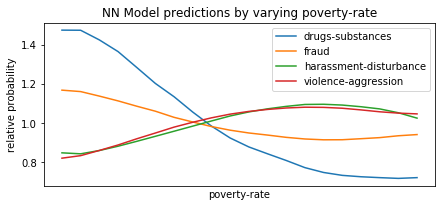

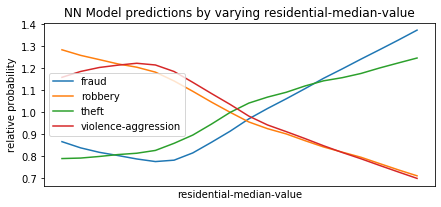

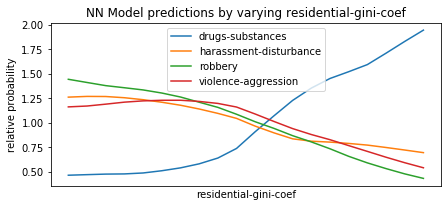

In [120]:
for label in interesting_cols:
    pr = model.predict(predictor_ranges[label])
    stds = []
    # Standardize
    for i in range(9):
        # Standardize
        mn = pr[:, i].mean()
        pr[:, i] = pr[:, i] / mn
        stds.append(pr[:, i].std())

    stdmean = np.array(stds).mean()
    
    fig, ax = plt.subplots(figsize=(7, 3))
    for i in range(9):
        # Plot only if variance is high
        if pr[:, i].std() > stdmean:
            plt.plot(pr[:, i], label=class_dict[i])

    plt.title("NN Model predictions by varying " + label)
    plt.xlabel(label)
    plt.ylabel("relative probability")
    plt.xticks([])
    plt.legend()
    plt.savefig('../figures/nn-interpretability/nn-predictions-'+label+'.png')
    plt.plot()

### Mean instead of median

<function matplotlib.pyplot.legend(*args, **kwargs)>

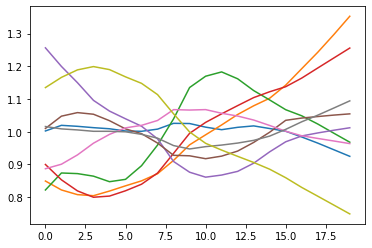

In [90]:
pr = model.predict(predictor_ranges['streetlights-night'])
# Standardize
for i in range(9):
    # Standardize
    mn = pr[:, i].mean()
    pr[:, i] = pr[:, i] / mn
    # Plot
    plt.plot(pr[:, i], label=class_dict[i])
    
plt.legend